# 7: Training the neural network for segmentation
> Using COCO dataset, we convert the images into B&W and train the neural network to predict the segmentation mask, using the image multiplited by the bounding box mask as input. The output is the segmentation mask.

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import segmentation_models_pytorch as smp
import torch
import fiftyone.utils.coco as fouc
from PIL import Image
import random
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

Migrating database to v0.18.0


INFO:fiftyone.migrations.runner:Migrating database to v0.18.0


In [ ]:
# Load the dataset
# !cp /content/drive/MyDrive/BCUFR/coco-2014.zip . 
# !unzip coco-2014.zip
# !mkdir -p /root/fiftyone
# !cp -r coco-2014 /root/fiftyone/coco-2014

In [ ]:
dataset = foz.load_zoo_dataset(
    "coco-2014",
    split="train",
    label_types=["segmentations"],
    max_samples=5000,
)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2014/train' if necessary


Found annotations at '/root/fiftyone/coco-2014/raw/instances_train2014.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2014/raw/instances_train2014.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading 'coco-2014' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2014' split 'train'


 100% |███████████████| 5000/5000 [1.2m elapsed, 0s remaining, 64.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [1.2m elapsed, 0s remaining, 64.3 samples/s]      


Dataset 'coco-2014-train-5000' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2014-train-5000' created


In [ ]:
dataset.compute_metadata()

In [ ]:
# Create the model
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid',
)
model = model.cuda()
model.train()

In [ ]:
# Load the pretrained model
# model = torch.load( '/content/drive/MyDrive/BCUFR/Deep Segmentation/model1.pth')
# model = model.cuda()
# model.train()

In [ ]:
class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.

    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        transforms_mask = None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.transforms_mask = transforms_mask
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        pilimg = Image.open(img_path).convert("RGB")
        img = np.array(pilimg)
        if sample.ground_truth is not None:
            detections = sample[self.gt_field].detections
            det = random.choice(detections)

            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det, metadata, category_id=category_id,
            )

            x, y, w, h = coco_obj.bbox
            mask = np.zeros((img.shape[0],img.shape[1]))
            minx = int(x)
            miny = int(y)
            maxx = int(x+w)
            maxy = int(y+h)
            mask[miny:maxy, minx:maxx] = 1
            # boxes = [[x, y, x + w, y + h]]
            target = np.zeros((img.shape[0],img.shape[1]))
            # target_mask = torch.as_tensor(det.mask)
            target_mask_w, target_mask_h, = det.mask.shape
            # print(target_mask_w, target_mask_h, torch.as_tensor(target_mask).shape)
            target[miny:miny+target_mask_w, minx:minx+target_mask_h] = det.mask
            # img = torch.concat([img, mask])

        else:
            mask = np.zeros((img.shape[0],img.shape[1]))
            target = np.zeros((img.shape[0],img.shape[1]))
        result = dict()
        result['image'] = img
        result['masks'] = [mask,target]
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
        if self.transforms_mask is not None:
            result['masks'][0] = self.transforms_mask(result['masks'][0])
            result['masks'][1] = self.transforms_mask(result['masks'][1])


        return result

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(800),
    T.CenterCrop(800),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Grayscale(3)
])
transform_mask = T.Compose([
    T.ToTensor(),
    T.Resize(800),
    T.CenterCrop(800),

    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_train = FiftyOneTorchDataset(dataset, transforms=transform, transforms_mask = transform_mask) 

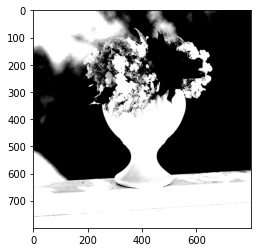

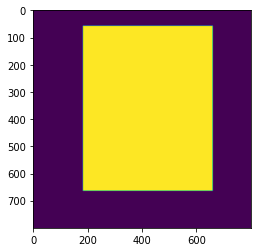

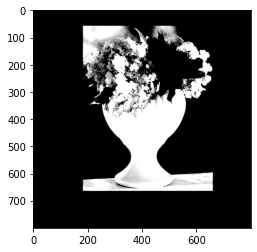

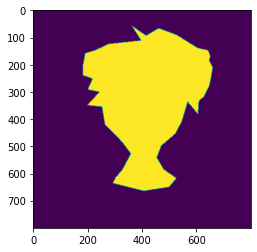

In [ ]:
import cv2
result = dataset_train.__getitem__(2)

plt.imshow(result['image'].permute(1,2,0))
plt.title('Image')
plt.show()
plt.imshow(result['masks'][0].permute(1,2,0)[:,:,0])
plt.title('Mask')
plt.show()
plt.imshow(result['masks'][0].permute(1,2,0)[:,:,:] * result['image'].permute(1,2,0))
plt.title('Masked Image')
plt.show()
plt.imshow(result['masks'][1].permute(1,2,0)[:,:,0])
plt.title('Target')
plt.show()


In [ ]:
segmentation = model((result['image'] * result['masks'][0]).cuda()[None,:,:,:].float())

In [ ]:
segmentation.shape

torch.Size([1, 1, 800, 800])

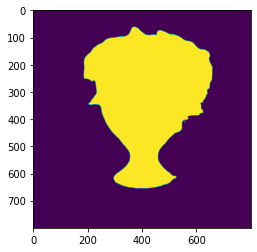

In [ ]:
plt.imshow(segmentation[0].permute(1,2,0)[:,:,0].cpu().detach().numpy())
cv2.imwrite('segmentation.png',segmentation[0].permute(1,2,0).cpu().detach().numpy() * 255)
plt.show()

## Training

In [ ]:
num_epochs = 100
import segmentation_models_pytorch.utils
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=8, shuffle=True,
    num_workers=1, pin_memory=True)

total_iter = len(train_loader)
global_loss = 0.14
for epoch in range(0, num_epochs):
    print(f'EPOCH: {epoch + 1}/{num_epochs}')

    train_loss = []
    for i, data in enumerate(train_loader):
        model.train()
        prediction = model((data['image'] * data['masks'][0]).cuda().float())

        loss_ = loss(prediction, data['masks'][1].cuda())
        train_loss.append(loss_.detach().cpu().item())

        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iter: {i}/{total_iter}, Loss: {np.mean(train_loss):.4f}')
    if np.mean(train_loss) < global_loss:
      torch.save(model, '/content/drive/MyDrive/BCUFR/Deep Segmentation/model1.pth')
      global_loss = np.mean(train_loss)  
      print('Model saved')

## Test

In [ ]:
res = model((result['image'] * result['masks'][0])[None,:,0].cuda().float())

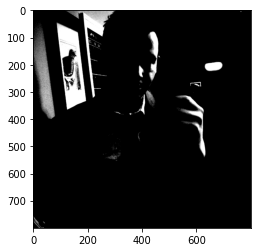

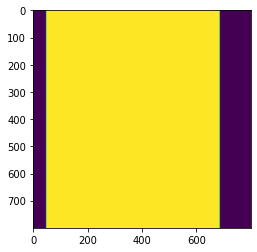

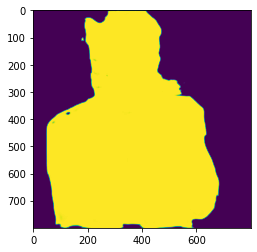

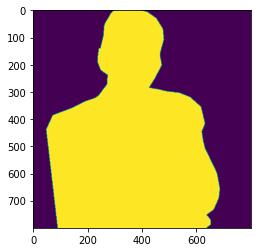

In [ ]:
result = dataset_train.__getitem__(990)
plt.imshow(result['image'].permute(1,2,0))
plt.title('Image')
plt.show()
plt.imshow(result['masks'][0].permute(1,2,0)[:,:,0])
plt.title('Mask')
plt.show()
res = model((result['image'] * result['masks'][0])[None,:,:].cuda().float())
plt.imshow(res.permute(2,3,0,1)[:,:,0,0].detach().cpu().numpy())
plt.title('Segmentation')
plt.show()
plt.imshow(result['masks'][1].permute(1,2,0)[:,:,0])
plt.title('Target')
plt.show()

## Eval

In [ ]:
dataset = foz.load_zoo_dataset(
    "coco-2014",
    split="validation",
    label_types=["segmentations"],
    max_samples=1000,
)

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(800),
    T.CenterCrop(800),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    T.Grayscale(3)
])
transform_mask = T.Compose([
    T.ToTensor(),
    T.Resize(800),
    T.CenterCrop(800),

    # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset_test = FiftyOneTorchDataset(dataset, transforms=transform, transforms_mask = transform_mask) 

In [ ]:
from tqdm import tqdm


num_epochs = 100
import segmentation_models_pytorch.utils
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=8, shuffle=False,
    num_workers=1, pin_memory=True)

model.eval()

metric_results = []
jaccard_results = []
precision = np.zeros(len(test_loader))
recall = np.zeros(len(test_loader))


true_positives = 0
false_positives = 0
false_negatives = 0
pbar = tqdm(train_loader)
for i, data in enumerate(pbar):
    with torch.no_grad():
      prediction = (model((data['image'] * data['masks'][0]).cuda().float()) > 0.5).long()
      # Flatten the outputs and labels tensors
      outputs = prediction.view(-1)
      labels = data['masks'][1].cuda().view(-1)

      # Count the number of true positive, false positive, and false negative predictions
      true_positives += ((outputs == 1) & (labels == 1)).sum().item()
      false_positives += ((outputs == 1) & (labels == 0)).sum().item()
      false_negatives += ((outputs == 0) & (labels == 1)).sum().item()


      metric_results.append(metrics[0](prediction, data['masks'][1].cuda()))
      pbar.set_description(f"Mean accuracy: {torch.tensor(metric_results).mean():.2f}")
      
    # Calculate the precision and recall values for the current threshold
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

Mean accuracy: 0.76: 100%|██████████| 125/125 [01:52<00:00,  1.11it/s]


In [ ]:
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")